In [1]:
using Pkg
Pkg.activate("../")
Pkg.status()
#Pkg.instantiate()

  Activating environment at `~/WORK/HPL/Code/ina-julia/Project.toml`


      Status `~/WORK/HPL/Code/ina-julia/Project.toml`
  [6e4b80f9] BenchmarkTools v1.1.4
  [a134a8b2] BlackBoxOptim v0.6.0
  [336ed68f] CSV v0.9.0
  [a93c6f00] DataFrames v1.2.2
  [0c46a032] DifferentialEquations v6.18.0
  [31c24e10] Distributions v0.24.18
  [a75be94c] GalacticOptim v2.0.3
  [7073ff75] IJulia v1.23.2
  [c7f686f2] MCMCChains v4.14.1
  [429524aa] Optim v1.4.1
  [91a5bcdd] Plots v1.21.3
  [c3572dad] Sundials v4.5.3
  [bd369af6] Tables v1.5.1
  [fce5fe82] Turing v0.17.4


# Load packages

In [2]:
using DifferentialEquations
using Sundials
using DataFrames: DataFrame
using CSV: File as CSVFile

using Plots
using BenchmarkTools

using Parameters
using Setfield

# Load CSV

In [3]:
read_csv(filename) = DataFrame(CSVFile(filename))

read_csv (generic function with 1 method)

In [4]:
dirname_data = "../data"
dirname_legends = joinpath(dirname_data, "legends")
dirname_protocols = joinpath(dirname_data, "protocols")

filename_legend_constants = joinpath(dirname_legends, "legend_constants_v3.csv")
filename_legend_states = joinpath(dirname_legends, "legend_states.csv")
filename_protocol = joinpath(dirname_protocols, "protocol_sparse.csv");

In [5]:
legend_states = read_csv(filename_legend_states)
legend_constants = read_csv(filename_legend_constants)
protocol = read_csv(filename_protocol);

In [6]:
find_step(t, protocol) = protocol.v[findfirst(x -> x >= t, protocol.t)]

function create_p_from_legend(legend)
    name = Symbol.(legend_constants.name)
    value = legend_constants.value
    p = (; zip(name, value)...)
end

create_p_from_legend (generic function with 1 method)

# Load equations

In [7]:
include("../src/models/ina.jl");
include("../src/models/currents.jl");
include("../src/losses.jl")

calculate_rmse (generic function with 1 method)

# Define model

In [8]:
function compute_algebraic(du, u, p, t)
    
    v_comp, v_p, v_m, m, h, j, I_out = u
        
    tau_m  = calculate_tau_m(v_m, p)
    tau_h  = calculate_tau_h(v_m, p)
    tau_j  = calculate_tau_j(v_m, p)
    
    m_inf  = calculate_m_inf(v_m, p)
    h_inf  = calculate_h_inf(v_m, p)
    
    v_cp   = calculate_v_cp(v_comp, p)

    I_leak = 0 # calculate_I_leak(v_m, p)
    I_Na   = calculate_I_Na(v_m, m, h, j, p)
    I_c    = 0 # calculate_I_c(v_m, v_cp, I_leak, I_Na,  p)  # or calculate_I_c(v_m, v_p, I_leak, I_Na,  p)
    I_p    = 0  # or calculate_I_p(v_cp, v_p, p)
    I_comp = 0 # calculate_I_comp(v_comp, p)
    
    I_in   = I_leak + I_Na + I_c - I_comp + I_p
    
    a = (;
     tau_m, tau_h, tau_j, m_inf, h_inf,
     v_cp,
     I_leak, I_Na, I_c, I_comp, I_in
    )
    
end

compute_algebraic (generic function with 1 method)

In [9]:
function compute_rates!(du, u, p, t; safety_factor=0.)
    
    v_comp, v_p, v_m, m, h, j, I_out = u
    
    a = compute_algebraic(du, u, p, t)
    
    du[1] = calculate_d_v_comp(v_comp, p)  # v_comp
    
    @unpack v_cp, I_leak, I_Na = a
    du[2] = 0#calculate_d_v_p(v_cp, v_p, p)  # v_p
    du[3] = calculate_d_v_m(v_m, v_cp, I_leak, I_Na, p)  # v_m
        
    @unpack m_inf, tau_m, h_inf, tau_h, tau_j = a
    du[4] = calculate_d_gate(m_inf, m, tau_m + safety_factor)  # m
    du[5] = calculate_d_gate(h_inf, h, tau_h + safety_factor)  # h
    du[6] = calculate_d_gate(h_inf, j, tau_j)  # j
        
    @unpack I_in = a
    @unpack tau_z = p
    du[7] = calculate_d_gate(I_in, I_out, tau_z)  # I_out
    
    nothing
end

compute_rates! (generic function with 1 method)

In [10]:
rhs = ODEFunction(compute_rates!, syms=[:v_comp, :v_p, :v_m, :m, :h, :j, :I_out]);

# Callbacks

In [83]:
function change_step_v1!(integrator)
    t = integrator.t
    v_c = find_step(t, protocol)
    integrator.p["v_c"] = v_c
    set_proposed_dt!(integrator, 1e-7)
    nothing
end

cb_step_v1  = PresetTimeCallback(protocol.t, change_step_v1!, save_positions=(false, false));

# Globals

In [161]:
u₀ = [-80., -80., -80., 0., 1., 1., 0.];
reltol = 1e-3
abstol = [1e-2, 1e-2, 1e-2, 1e-4, 1e-4, 1e-4, 1e-2]
solver = CVODE_BDF();
dt = 1e-9  # initial
tspan_initial = (0., 10.)
tspan = (0., 5.)
saveat = tspan[1]: 5e-5: tspan[2]

0.0:5.0e-5:5.0

# Loss

In [13]:
kwargs_loss_robust = (α=-2, c=0.1)

(α = -2, c = 0.1)

In [14]:
p_dict = Dict{String, Real}(zip(legend_constants.name, legend_constants.value));
p_dict["α"] = kwargs_loss_robust.α

-2

In [15]:
p_keys_opt_m = ["a0_m", "s_m", "b0_m", "delta_m", "v_half_m", "k_m"]
p_keys_opt_h = ["a0_h", "s_h", "b0_h", "delta_h", "v_half_h", "k_h"]
p_keys_opt_j = ["tau_j_const", "a0_j", "s_j", "b0_j", "delta_j"]

p_keys_opt_INa = ["g_max"]

p_keys_opt_other = ["α"]  # loss_robust
p_keys_opt_patch = ["c_p","c_m","R","R_f","g_leak","tau_z","x_c_comp","x_r_comp"]
p_keys_alpha = ["alpha"]

1-element Vector{String}:
 "alpha"

In [16]:
# p_keys_opt = vcat(p_keys_opt_m, p_keys_opt_h, p_keys_opt_j)
p_keys_opt = vcat(p_keys_opt_INa, p_keys_opt_other, p_keys_opt_m, p_keys_opt_h, p_keys_opt_j)#, p_keys_opt_patch, p_keys_alpha)

19-element Vector{String}:
 "g_max"
 "α"
 "a0_m"
 "s_m"
 "b0_m"
 "delta_m"
 "v_half_m"
 "k_m"
 "a0_h"
 "s_h"
 "b0_h"
 "delta_h"
 "v_half_h"
 "k_h"
 "tau_j_const"
 "a0_j"
 "s_j"
 "b0_j"
 "delta_j"

In [17]:
legend_subset = legend_constants[in(p_keys_opt).(legend_constants.name), :]

18×5 DataFrame
 Row │ name         value        bound_1     bound_2     is_log 
     │ String15…    Float64      Float64     Float64     Int64  
─────┼──────────────────────────────────────────────────────────
   1 │ a0_m         16529.1      10000.0     100000.0         1
   2 │ b0_m           386.7        100.0       1000.0         1
   3 │ delta_m         22.823        1.0        100.0         0
   4 │ s_m             12.8321       1.0        100.0         0
   5 │ a0_h             6.26         1.0        100.0         1
   6 │ b0_h         58131.4      10000.0     100000.0         1
   7 │ delta_h         10.2758       1.0        100.0         0
   8 │ s_h             21.62         1.0        100.0         0
   9 │ a0_j             0.6462       0.01         1.0         1
  10 │ b0_j         11358.3       5000.0     100000.0         1
  11 │ delta_j          7.445        1.0        100.0         0
  12 │ s_j             69.417        1.0        100.0         0
  13 │ tau_j_const      0.00132      0.0005       0.005       1
  14 │ g_max         3392.4       1000.0      10000.0         1
  15 │ v_half_m        28.358       10.0         60.0         0
  16 │ v_half_h        59.6912      50.0        100.0         0
  17 │ k_m              7.66677      1.0         10.0         0
  18 │ k_h              5.50777      1.0         10.0         0

In [18]:
legend_subset.is_log .= true;

In [19]:
mask_log = Dict(zip(legend_subset.name,
                    Array{Bool}(legend_subset.is_log)));
mask_log["α"] = Bool(0)

false

In [21]:
function prepare_p(x)
    
    @assert length(x) == length(p_keys_opt)
    
    p = deepcopy(p_dict)
    for (k, v, is_log) in zip(p_keys_opt, x, mask_log)
        p[k] = mask_log[k] ? exp(v) : v
    end
    
    p["α"] = kwargs_loss_robust.α
    
    return p
    
end

prepare_p (generic function with 1 method)

In [22]:
function solve_model(p)
    prob_remade = remake(prob; p=p)
    sol = solve(prob_remade; solve_kwargs...)
    return sol
end

solve_model (generic function with 1 method)

In [23]:
function sanity_checks(p)  # TODO
    v_m_range = -100:1:50
    
    τ_m, τ_h, τ_j = [map(v_m -> calculate_τ(v_m, p), v_m_range) for calculate_τ ∈ (calculate_tau_m,
                                                                                   calculate_tau_h, 
                                                                                   calculate_tau_j)]
    
    (τ_m_max, τ_m_idxmax), (τ_h_max, τ_h_idxmax), (τ_j_max, τ_j_idxmax) = map(τ -> findmax(τ), (τ_m, τ_h, τ_j))
    τ_m_min, τ_h_min, τ_j_min = map(τ -> min(τ...), (τ_m, τ_h, τ_j))

    flags = [all(1e-7 .< τ_m_min .< 1e-3),
             all(1e-8 .< τ_h_min .< 1e-2),
             all(5e-4 .< τ_j_min .< 2.),
             τ_m_max > 4e-5,
             τ_h_max > 1e-3,
             τ_j_max > 8e-2,
             (-90. < v_m_range[τ_m_idxmax] < 0.),
             (-90. < v_m_range[τ_h_idxmax] < 0.),
             (-90. < v_m_range[τ_j_idxmax] < 0.)]
end

sanity_checks (generic function with 1 method)

In [25]:
function calculate_loss(x)
    
#     println("*", x[1:3])
    
    p = prepare_p(x)
    is_ok = all(sanity_checks(p))
    if !is_ok
        return Inf
    end
    sol = solve_model(p)
    
    if sol.retcode ≠ :Success
        loss = Inf
    else
        #loss = calculate_rmse(sol[:I_out], data)
        residuals = sol[:I_out] - data
        loss = calculate_loss_robust.(residuals, α=p["α"], c=kwargs_loss_robust.c)
        loss = mean(loss)
    end
    return loss
    
end

calculate_loss (generic function with 1 method)





# Generate data

In [26]:
x₀ = [mask_log[k] ? log.(p_dict[k]) : p_dict[k] for k in p_keys_opt];

In [27]:
p = prepare_p(x₀)

Dict{String, Real} with 31 entries:
  "g_max"       => 3392.4
  "s_m"         => 12.8321
  "b0_j"        => 11358.3
  "tau_z"       => 0.000100034
  "b0_m"        => 386.7
  "b0_h"        => 58131.4
  "v_half_h"    => 59.6912
  "tau_j_const" => 0.00132
  "c_m"         => 2.47302e-11
  "s_j"         => 69.417
  "v_off"       => -2.0
  "R_f"         => 3.26421e5
  "c_p"         => 4.50296e-13
  "s_h"         => 21.62
  "k_h"         => 5.50777
  "x_c_comp"    => 0.01
  "alpha"       => 0.75
  "v_rev"       => 18.0
  "α"           => -2
  "v_half_m"    => 28.358
  "delta_h"     => 10.2758
  "x_r_comp"    => 0.2
  "v_c"         => -80.0
  "g_leak"      => 0.481244
  "delta_m"     => 22.823
  ⋮             => ⋮

In [128]:
prob = ODEProblem(rhs, u₀, tspan, p, callback=cb_step_v1)
solve_kwargs = (; reltol, abstol, solver, saveat, dt)

(reltol = 0.001, abstol = [0.01, 0.01, 0.01, 0.0001, 0.0001, 0.0001, 0.01], solver = CVODE_BDF{:Newton, :Dense, Nothing, Nothing}(0, 0, 0, false, 10, 5, 7, 3, 10, nothing, nothing, 0), saveat = 0.0:5.0e-5:5.0, dt = 1.0e-7)

In [129]:
sol = solve_model(p);

In [119]:
@benchmark solve_model(p)

BenchmarkTools.Trial: 10 samples with 1 evaluation.
 Range (min … max):  500.689 ms … 536.205 ms  ┊ GC (min … max): 12.24% … 15.07%
 Time  (median):     507.539 ms               ┊ GC (median):    11.25%
 Time  (mean ± σ):   510.220 ms ±  10.598 ms  ┊ GC (mean ± σ):  11.70% ±  1.87%

  █ █ █  █  █ ██     █            █                           █  
  █▁█▁█▁▁█▁▁█▁██▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  501 ms           Histogram: frequency by time          536 ms <

 Memory estimate: 321.68 MiB, allocs estimate: 9578794.

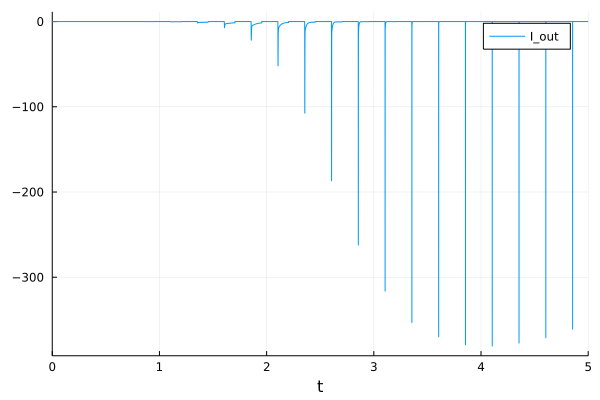

In [130]:
plot(sol, vars=[:I_out])

In [132]:
data = copy(sol[:I_out]);

In [133]:
calculate_loss(x₀)

0.0

In [134]:
sanity_checks(p)

9-element Vector{Bool}:
 1
 1
 1
 1
 1
 1
 1
 1
 1

In [135]:
bounds = []

for key ∈ p_keys_opt
    if key == "α"
        append!(bounds, [(-5., 0.)])
        continue
    end
    idx = findfirst(legend_subset.name .== key)
    lb, ub = legend_subset.bound_1[idx], legend_subset.bound_2[idx]
    b = (lb, ub)
    if mask_log[key]
        b = map(x -> log.(x), b)
    end
    append!(bounds, [b])
end

# Monte Carlo

In [141]:
n_inside = 0
n_total = 100_000

insiders = zeros(Int, size(sanity_checks(p)))
valid_ps = Vector{Vector{Float64}}([])

for i in 1: n_total    
    x_rand = [b[1] + rand() * (b[2] - b[1]) for b in bounds]
    p_rand = prepare_p(x_rand)
    flags = sanity_checks(p_rand)
    insiders .+= flags
    n_inside += all(flags)
    if all(flags)
        # append!(valid_ps, [collect(values(p_rand))])
        append!(valid_ps, [x_rand])
    end
end

In [142]:
append!(valid_ps, [x₀]);

In [143]:
valid_ps = hcat(valid_ps...);

In [144]:
insiders ./ n_total * 100

9-element Vector{Float64}:
  26.915
  36.211
 100.0
  83.22
  44.743
  32.193
  91.049
  83.917
  74.725

In [145]:
n_inside / n_total * 100

0.422

In [152]:
using CSV, Tables
CSV.write("../results/valid_ps.csv",
          Tables.table(transpose(valid_ps)),
          header=p_keys_opt)

"../results/valid_ps.csv"

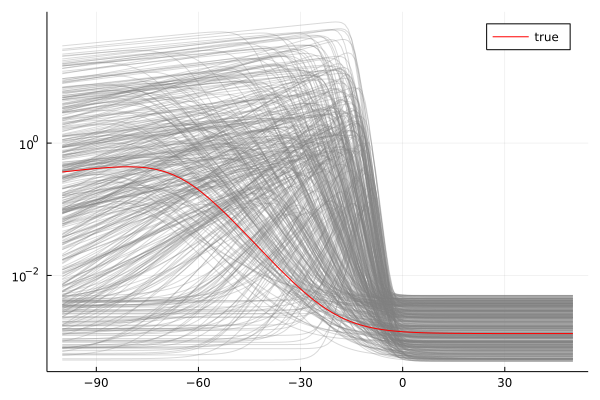

In [149]:
pl = plot()

stride = 1
v_m_range = -100: 50

f = calculate_tau_j


for x in eachrow(transpose(valid_ps)[1: stride: end, :])

    v_m_range = -100:1:50
    τ = map(v_m -> f(v_m, prepare_p(Vector(x))), v_m_range)

    plot!(v_m_range, τ, color="grey", alpha=0.3, label=nothing)
end

plot!(v_m_range, map(v_m -> f(v_m, p), v_m_range), color="red", label="true")

plot!(yaxis=:log)

display(pl)

# Optimize

In [163]:
import BlackBoxOptim: bboptimize, best_candidate

In [158]:
bounds = Vector{Tuple{Float64, Float64}}(bounds)

19-element Vector{Tuple{Float64, Float64}}:
 (6.907755278982137, 9.210340371976184)
 (-5.0, 0.0)
 (9.210340371976184, 11.512925464970229)
 (0.0, 4.605170185988092)
 (4.605170185988092, 6.907755278982137)
 (0.0, 4.605170185988092)
 (2.302585092994046, 4.0943445622221)
 (0.0, 2.302585092994046)
 (0.0, 4.605170185988092)
 (0.0, 4.605170185988092)
 (9.210340371976184, 11.512925464970229)
 (0.0, 4.605170185988092)
 (3.912023005428146, 4.605170185988092)
 (0.0, 2.302585092994046)
 (-7.600902459542082, -5.298317366548036)
 (-4.605170185988091, 0.0)
 (0.0, 4.605170185988092)
 (8.517193191416238, 11.512925464970229)
 (0.0, 4.605170185988092)

In [159]:
rhs = ODEFunction((du, u, p, t) -> compute_rates!(du, u, p, t, 1e-6),
                  syms=[:v_comp, :v_p, :v_m, :m, :h, :j, :I_out]);

In [160]:
res = bboptimize(calculate_loss; SearchRange=bounds, MaxTime=10. * 60., TraceInterval=10,
                  PopulationSize=100,
                 );

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64}, BlackBoxOptim.RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
10.57 secs, 1279 evals, 1179 steps, improv/step: 0.953 (last = 0.9534), fitness=0.295457130


┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/andrey/.julia/packages/SciMLBase/UIp7W/src/integrator_interface.jl:351


20.96 secs, 2424 evals, 2324 steps, improv/step: 0.947 (last = 0.9406), fitness=0.294362130
31.69 secs, 3171 evals, 3071 steps, improv/step: 0.937 (last = 0.9036), fitness=0.294362130
41.85 secs, 3686 evals, 3586 steps, improv/step: 0.933 (last = 0.9146), fitness=0.294362130
52.02 secs, 4012 evals, 3912 steps, improv/step: 0.928 (last = 0.8681), fitness=0.261907569
62.37 secs, 4366 evals, 4266 steps, improv/step: 0.918 (last = 0.8107), fitness=0.261907569
72.73 secs, 4588 evals, 4488 steps, improv/step: 0.914 (last = 0.8423), fitness=0.261907569
82.93 secs, 4797 evals, 4697 steps, improv/step: 0.909 (last = 0.7847), fitness=0.261907569
93.30 secs, 4963 evals, 4863 steps, improv/step: 0.906 (last = 0.8253), fitness=0.261907569
103.48 secs, 5192 evals, 5092 steps, improv/step: 0.902 (last = 0.8253), fitness=0.261907569
113.59 secs, 5358 evals, 5258 steps, improv/step: 0.898 (last = 0.7831), fitness=0.258646927
123.96 secs, 5618 evals, 5518 steps, improv/step: 0.893 (last = 0.7923), fitne

In [164]:
x_bbo = best_candidate(res);
x_best = copy(x_bbo);

# Scipy

In [ ]:
using PyCall
so = pyimport("scipy.optimize");

In [328]:
res = so.minimize((x, args) -> calculate_loss(x), x_best, bounds,
                  method="Nelder-Mead", options=Dict(:maxiter => 1000))

Dict{Any, Any} with 8 entries:
  "fun"           => 0.202484
  "nit"           => 1000
  "nfev"          => 1408
  "status"        => 2
  "success"       => false
  "message"       => "Maximum number of iterations has been exceeded."
  "x"             => [8.35681, -1.99849, 7.54235, 4.14701, 6.59247, 3.22922, 2.…
  "final_simplex" => ([8.35681 -1.99849 … 13.961 0.00106738; 8.35941 -1.99699 ……

In [ ]:
x_best = res["x"]

# Optim.jl

In [2]:
using Optim

In [1]:
res = optimize(calculate_loss, x_best, LBFGS(),
               Optim.Options(iterations = 100, show_trace = true))

LoadError: UndefVarError: LBFGS not defined

In [168]:
x_best = Optim.minimizer(res)

19-element Vector{Float64}:
  9.153592746361324
 -1.6139138781651896
 10.777934364070909
  3.5924364519033314
  5.6612507705525505
  2.749772818412685
  3.2432471695338694
  1.9549547339736533
  1.1343430569416713
  3.323322223023171
  9.61284166313372
  1.9253119144682713
  3.990530668631676
  0.8107233561691094
 -5.93735913482257
 -1.1744523929638648
  3.3261829841569908
  8.729816804828676
  0.9607197347082919

# CMAES

In [170]:
using CMAEvolutionStrategy

In [182]:
res = minimize(calculate_loss, x_best, .001;
       lower = lb,
       upper = ub,
       maxtime = 60.)

(6_w,12)-aCMA-ES (mu_w=3.7,w_1=40%) in dimension 19 (seed=2829330170940929681, 2021-09-11T13:01:28.654)
  iter   fevals   function value      sigma  axis ratio   time[s]
     1       12   1.74758364e-01   9.56e-04   1.133e+00     9.501
     2       24   1.74731887e-01   9.34e-04   1.157e+00    20.400
     3       36   1.74600787e-01   9.48e-04   1.235e+00    27.921
     4       48   1.74612637e-01   9.61e-04   1.264e+00    35.874
     5       60   1.74441610e-01   9.68e-04   1.291e+00    44.117
     6       72   1.74455478e-01   1.04e-03   1.430e+00    52.600
     7       84   1.74161178e-01   1.15e-03   1.518e+00    60.605


Optimizer{Parameters,BasicLogger,Stop}


(6_w,12)-aCMA-ES (mu_w=3.7,w_1=40%) in dimension 19 (seed=2829330170940929681, 2021-09-11T13:02:19.758)
  termination reason: maxtime = 60.0 (2021-09-11T13:02:19.758)
  lowest observed function value: 0.1740257909002125 at [9.144506326829495, -1.6008022220693523, 10.78974317881167, 3.584946958557025, 5.658557362341001, 2.755338337705548, 3.2231211862341467, 1.973958649492858, 1.1250792641076226, 3.271482056104379, 9.632311323551264, 1.9263412875689614, 3.9972065484196095, 0.8499956538930034, -5.940187421794626, -1.1500470516199786, 3.3284070578232674, 8.745844453279272, 0.9588392007291515]
  population mean: [9.144331368485664, -1.6012414109902369, 10.78989880458632, 3.585981984962225, 5.658590163982203, 2.7559091699302827, 3.2239498000757716, 1.9733780491994484, 1.1255226389590214, 3.271531352752155, 9.632120191949108, 1.9259233677918053, 3.9971241080330153, 0.8492546807507974, -5.939314419998358, -1.1511060671771212, 3.3276383811868113, 8.745405022933774, 0.9595357417399254]


In [183]:
x_best = xbest(res)

19-element Vector{Float64}:
  9.144506326829495
 -1.6008022220693523
 10.78974317881167
  3.584946958557025
  5.658557362341001
  2.755338337705548
  3.2231211862341467
  1.973958649492858
  1.1250792641076226
  3.271482056104379
  9.632311323551264
  1.9263412875689614
  3.9972065484196095
  0.8499956538930034
 -5.940187421794626
 -1.1500470516199786
  3.3284070578232674
  8.745844453279272
  0.9588392007291515

# Results

In [171]:
lb = [b[1] for b in bounds]
ub = [b[2] for b in bounds];

In [332]:
df = DataFrame(Name = p_keys_opt,
          True = x₀,
          Lb = lb,
          Best = x_best,
          Ub = ub);
# df[:, 2:end] = exp.(df[:, 2:end]);
df.relerr = (df.Best - df.True) ./ df.Best * 100.;

In [333]:
df

19×6 DataFrame
 Row │ Name         True       Lb        Best         Ub        relerr        
     │ String       Float64    Float64   Float64      Float64   Float64       
─────┼────────────────────────────────────────────────────────────────────────
   1 │ g_max         8.12929    6.90776   8.35681      9.21034      2.7225
   2 │ α            -2.0       -5.0      -1.99849      0.0         -0.0756832
   3 │ a0_m          9.71288    9.21034   7.54235     11.5129     -28.7779
   4 │ s_m           2.55195    0.0       4.14701      4.60517     38.4629
   5 │ b0_m          5.95765    4.60517   6.59247      6.90776      9.62954
   6 │ delta_m       3.12777    0.0       3.22922      4.60517      3.14172
   7 │ v_half_m      3.34491    2.30259   2.81442      4.09434    -18.849
   8 │ k_m           2.0369     0.0       2.2474       2.30259      9.3665
   9 │ a0_h          1.83418    0.0       1.74915      4.60517     -4.86118
  10 │ s_h           3.07362    0.0       4.64134      4.60517     33.7773
  11 │ b0_h         10.9705     9.21034   8.42807     11.5129     -30.1657
  12 │ delta_h       2.32979    0.0       2.13506      4.60517     -9.12098
  13 │ v_half_h      4.08918    3.91202   3.96864      4.60517     -3.0375
  14 │ k_h           1.70616    0.0       0.116272     2.30259  -1367.39
  15 │ tau_j_const  -6.63012   -7.6009   -6.17732     -5.29832     -7.33011
  16 │ a0_j         -0.436646  -4.60517  -2.39023      0.0         81.732
  17 │ s_j           4.24013    0.0       2.82508      4.60517    -50.0891
  18 │ b0_j          9.3377     8.51719  13.961       11.5129      33.1156
  19 │ delta_j       2.00754    0.0       0.00106738   4.60517     -1.87982e5

In [153]:
calculate_loss(x_bbo), calculate_loss(x_best)

(0.25409124423935614, 0.1679927209645241)

In [154]:
sol_best = solve_model(prepare_p(x_best));

In [155]:
plot(sol_best, vars=[:I_out])
plot!(sol_best.t .- 2e-2, data)
plot!(ylims=(-5, 0.5))

In [370]:
residuals = ...

plot(sol_best.t, calculate_loss_robust.(residuals,
                                         c=0.1, #kwargs_loss_robust.c,
                                         α=-3, #p_best["α"]
                                        ))

plot!(sol_best.t, calculate_loss_robust.(residuals,
                                         c=kwargs_loss_robust.c,
                                         α=p_best["α"]
                                        ))

LoadError: UndefVarError: residuals not defined

# Test unstable sol

In [101]:
x_initial = [b[1] + rand() * (b[2] - b[1]) for b in bounds];
calculate_loss(x_initial)

Inf

In [102]:
st = nothing # :Success

while st != :Success
    x_rand = [b[1] + rand() * (b[2] - b[1]) for b in bounds];

    p_rand = prepare_p(x_rand)
    if !all(sanity_checks(p_rand))
        continue
    end
    break
    sol_best = solve_model(p_rand)
    st = sol_best.retcode
end

In [103]:
p_rand

LoadError: UndefVarError: p_rand not defined

In [410]:
calculate_loss(x_rand)
# sol_best = solve_model(p_rand);

In [412]:
calculate_loss(x_rand)

0.0

In [123]:
sanity_check(p_rand)

true

In [124]:
function euler_step(u, du, dt)
    @. u + dt * du
end

euler_step (generic function with 1 method)

In [125]:
du = zeros(size(u₀))
t = 0.
dt = 1e-9

compute_rates!(du, u₀, p_rand, t)

In [126]:
du

7-element Vector{Float64}:
     0.0
     0.0
 -3241.8188743330375
    -0.001745355753884301
   -74.12086952352222
    -1.2462125438149578
    -3.079115455523512e-12

In [127]:
euler_step(u₀, du, 1e-9)

7-element Vector{Float64}:
 -80.0
 -80.0
 -80.00000324181887
   9.999825464424611e-8
   0.9999989258791304
   0.9999989987537874
  -3.0791154555235123e-21